# **[Question 4]  Leveraging a Pretrained Model for CIFAR-10 (10 marks)**


> Objective: Use a pretrained model from TensorFlow's Keras applications  **as a feature extractor or for fine-tuning on the CIFAR-10 dataset**, and a**chieve >90% accuracy on the test dataset** of CIFAR-10.

In [9]:
#import the libraries and packages needed
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np


> **Requirement**: Dataset Preparation: Load the CIFAR-10 dataset, applying normalization and any required preprocessing to match the input format of the pretrained model.

In [10]:
def preprocess_data(X, Y, num_class=10):
    """
    returns preprocessed data
    by using the resnet50 preprocess_input function which normalizes the input data and
    converts the labels to one-hot encoding using the to_categorical function with 10 classes
    """
    X_p = tf.keras.applications.resnet50.preprocess_input(X)
    #X_p = X.astype('float32') / 255.0
    Y_p = tf.keras.utils.to_categorical(Y, num_class)
    return X_p, Y_p

def preprocess_data2(X, Y, num_class=10):
    """
    Manually preprocesses the data by replicating the steps performed in the
    resnet50 preprocess_input function which are:
    - Convert RGB to BGR
    - Subtract the mean value of each channel of the ImageNet dataset
    """
    # Convert RGB to BGR
    X_p = X[..., ::-1].astype('float32')

    # Subtract ImageNet mean pixel value for each channel
    # Refer to this https://stackoverflow.com/questions/44962433/image-preprocessing-of-finetune-in-resnet & https://towardsdatascience.com/preprocessing-layer-in-cnn-models-for-tf2-d471e61ddc2e
    mean = [103.939, 116.779, 123.68]
    X_p[..., 0] -= mean[0]
    X_p[..., 1] -= mean[1]
    X_p[..., 2] -= mean[2]

    # Convert labels to one-hot encoding
    Y_p = tf.keras.utils.to_categorical(Y, num_class)

    return X_p, Y_p

In [11]:
# Load the CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

# preprocess data using the preprocess_data function
#''''
X_train_p, Y_train_p = preprocess_data2(X_train, Y_train)
X_test_p, Y_test_p = preprocess_data2(X_test, Y_test)
#'''

In [12]:
# Sanity check of the shape of the preprocessed data, datapoints statistics,
# and labels if its turned into one-hot encoding
print(X_train_p.shape, Y_train_p.shape)
print(X_test_p.shape, Y_test_p.shape)
print('number of classes:',num_class:=Y_train_p.shape[1])
print('first 5 labels:\n', Y_train_p[:5],'\n')
print('max, and min of the datapoints:', X_train_p.max(), X_train_p.min())

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)
number of classes: 10
first 5 labels:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]] 

max, and min of the datapoints: 151.061 -123.68


> **Requirement**: Model Selection and Modification: Choose a pretrained model (e.g., ResNet, VGG16) and modify it for CIFAR-10 classification. Describe how you adapt the model for the 10 classes of CIFAR-10 (e.g., modifying the top layer, adjusting input size).

> why is `modifying the top layer` my approach?
- The images in CIFAR-10 are generally simple and has lesser variability to ImageNet. The objects like planes, cars, birds, etc are generally centered and occupies a large portion of the frame. The images used to train ResNet50 were  under data augmentation which would have a broader and diverse/complexity captured. Since the new CIFAR10 dataset is much smaller or less diverse, can leverage the model to using pre-learned features (shapes, curves, lines, edges etc). But we will try out and see various architectures experimentation before deciding to fine tune or not. If it is suffice, will not fine-tune (unfreezing some layers) and train as a whole as it is computationally expensive in google colab

> To use ResNet50 pretrained on ImageNet dataset as a feature extractor
- To **remove** the final layer of ResNet50 that is used to classify for the ImageNet data, aka base_model (without top layer) : serves as a feature extractor
- To add a dense layer with 10 classes with softmax activations because the original classifier has 1000 classes (from ImageNet)
- To freeze all the prior layers of ResNet50, and perform transfer learning on the layer(s) added to adapt to learning how to classify the CIFAR10 images
- Stacking: Add upscaling of CIFAR10 images (32x32x3) to match the spatial dimension of ResNet50 (224x224x3) as it was trained on ImageNet 224x224x3 images -> ResNet50 as base model -> added layer(s)

In [13]:
# Load ResNet50 model without the top layer
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze ResNet50 layers

> **Model 1 architecture**: Upscaling -> Base Model (ResNet50) -> Flatten -> Dense layer with Softmax Activation (Classifier)

In [14]:
# Build the model1
model1 = models.Sequential([
    # Upscale images
    layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear"),
    # Add the pre-trained ResNet50 base model
    base_model,
    # Add custom layers on top
    layers.Flatten(),
    layers.Dense(10, activation='softmax')  # For CIFAR-10 classes
])

In [15]:
# Compile the model1
model1.compile(optimizer=optimizers.SGD(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

'''
# Describe the model architecture and params for sanity check
model1.summary()
'''

'\n# Describe the model architecture and params for sanity check\nmodel1.summary()\n'

In [16]:
# Train the model
model1.fit(X_train_p, Y_train_p, batch_size=128, epochs=5,
          validation_data=(X_test_p, Y_test_p))

Epoch 1/5
391/391 [==============================] - 186s 467ms/step - loss: 6.6056 - accuracy: 0.8401 - val_loss: 3.9673 - val_accuracy: 0.8560
Epoch 2/5
391/391 [==============================] - 177s 453ms/step - loss: 1.3011 - accuracy: 0.9262 - val_loss: 2.1307 - val_accuracy: 0.8943
Epoch 3/5
391/391 [==============================] - 163s 416ms/step - loss: 0.5988 - accuracy: 0.9542 - val_loss: 2.1006 - val_accuracy: 0.9016
Epoch 4/5
391/391 [==============================] - 176s 450ms/step - loss: 0.2152 - accuracy: 0.9760 - val_loss: 1.6603 - val_accuracy: 0.9107
Epoch 5/5
391/391 [==============================] - 163s 417ms/step - loss: 0.1177 - accuracy: 0.9861 - val_loss: 1.6524 - val_accuracy: 0.9113


> **Model1 Evaluation & Mitigation Proposal **: Observed that the model is overfitting quite badly from epoch 2/3 onwards as the gap between train acc and test acc is widening. Upon research, decided to use Global Average Pooling (GAP)to find the precense of a global feature across all 3 channels, preserving spatial information to more meaningful, instead of purely just flattening before feeding it into the classifier (softmax). As a result of reducing the number of parameters, this can help prevent overfitting through the dimension reduction

> Reference: https://stackabuse.com/dont-use-flatten-global-pooling-for-cnns-with-tensorflow-and-keras/ , https://paperswithcode.com/method/global-average-pooling#:~:text=Global%20Average%20Pooling%20is%20a%20pooling%20operation%20designed,the%20classification%20task%20in%20the%20last%20mlpconv%20layer.

> **Model2 Architecture**: Upscaling -> Base Model (ResNet50) / without top classification layer -> `Global Average Pooling` -> Fully Connected Layer with Softmax Activation (Classifier)

In [18]:
# Build the model2
model2 = models.Sequential([
    # Upscale images
    layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear"),
    # Add the pre-trained ResNet50 base model
    base_model,
    # Add custom layers on top
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax')  # For CIFAR-10 classes
])

In [19]:
# Compile the model2
model2.compile(optimizer=optimizers.SGD(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Train the model2
# will just start small with 5 epochs
model2.fit(X_train_p, Y_train_p, batch_size=128, epochs=5,
          validation_data=(X_test_p, Y_test_p))

Epoch 1/5
391/391 [==============================] - 182s 457ms/step - loss: 0.5833 - accuracy: 0.8085 - val_loss: 0.4186 - val_accuracy: 0.8601
Epoch 2/5
391/391 [==============================] - 177s 452ms/step - loss: 0.3638 - accuracy: 0.8762 - val_loss: 0.3695 - val_accuracy: 0.8745
Epoch 3/5
391/391 [==============================] - 162s 415ms/step - loss: 0.3264 - accuracy: 0.8895 - val_loss: 0.3390 - val_accuracy: 0.8866
Epoch 4/5
391/391 [==============================] - 176s 449ms/step - loss: 0.3049 - accuracy: 0.8953 - val_loss: 0.3256 - val_accuracy: 0.8922
Epoch 5/5
391/391 [==============================] - 177s 452ms/step - loss: 0.2903 - accuracy: 0.9014 - val_loss: 0.3207 - val_accuracy: 0.8931


> **Model 2 evauation** : Improved performance with using GAP but unable to hit 90%. Seems promising with a longer epochs used. Will also incorporate early stopping with specified longer epochs.

> **Model 2+ architecture**: Upscaling -> Base Model (ResNet50) / without top classification layer -> Global Average Pooling -> Fully Connected Layer with Softmax Activation (Classifier)

> Longer Epochs used with early stopping on validation accuracy being monitored. Used default hyperparameters `min_delta=0.01` and `patience=3`, `epoch=10`

> while increasing hard fix of epoch=10 would indefinitely and possibly raise the accuracy, but it requires much more computational resources (means $ in google colab), here i will perform second stage of training by continuing from **last state**

In [21]:
# initialise the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1, mode='max', restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint('best_resnet50_variant_CIFAR10.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [22]:
# fit and train the model2 with the callbacks
history = model2.fit(X_train_p, Y_train_p, batch_size=128, epochs=10,
                     validation_data=(X_test_p, Y_test_p),
                     callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9049
Epoch 1: val_accuracy improved from -inf to 0.89590, saving model to best_resnet50_variant_CIFAR10.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


391/391 [==============================] - 164s 420ms/step - loss: 0.2792 - accuracy: 0.9049 - val_loss: 0.3156 - val_accuracy: 0.8959
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9080
Epoch 2: val_accuracy improved from 0.89590 to 0.90010, saving model to best_resnet50_variant_CIFAR10.h5
391/391 [==============================] - 176s 450ms/step - loss: 0.2708 - accuracy: 0.9080 - val_loss: 0.3030 - val_accuracy: 0.9001
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.9109
Epoch 3: val_accuracy did not improve from 0.90010
391/391 [==============================] - 177s 452ms/step - loss: 0.2629 - accuracy: 0.9109 - val_loss: 0.3046 - val_accuracy: 0.8950
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9130Restoring model weights from the end of the best epoch: 1.

Epoch 4: val_accuracy did not improve from 0.90010
391/391 [==============================] 

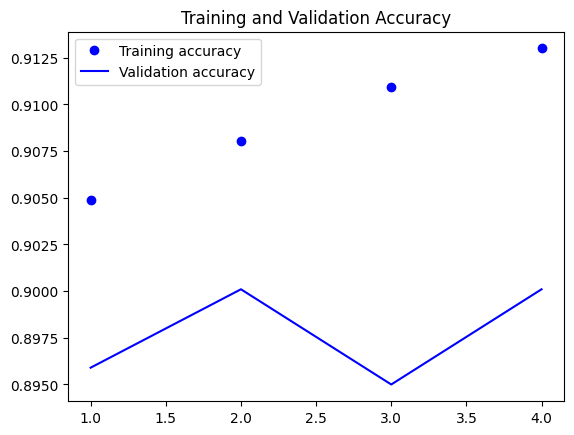

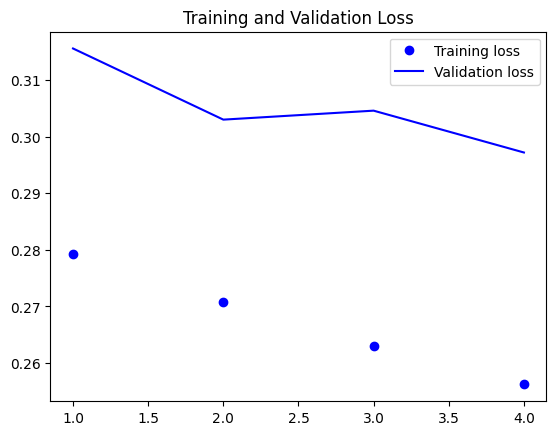

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# accuracy plot
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

# loss plot
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

*stop* here ------